In [ ]:
!pip install pymc3==0.14.0

In [2]:
import pymc3 as pm
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd

data = pd.read_csv(
  'https://raw.githubusercontent.com/haensel-ams/recruitment_challenge/master/DataScience_202209/MMM_test_data.csv',
  parse_dates=['start_of_week'],
  index_col='start_of_week'
)

X = data.drop(columns=['revenue'])
y = data['revenue']

In [4]:
data.head()

,revenue,spend_channel_1,spend_channel_2,spend_channel_3,spend_channel_4,spend_channel_5,spend_channel_6,spend_channel_7
start_of_week,,,,,,,,
2020-08-30,157906.75,2625.48,262.71,12954.12,3609.63,12955.29,12659.12,19379.79
2020-06-09,186425.68,2634.01,108.66,8760.28,4560.60,12747.70,12338.18,22473.45
2020-09-13,161607.39,2087.08,110.32,7155.42,4362.96,15015.41,10811.15,22596.05
2020-09-20,180089.13,1690.70,52.79,15185.22,3883.41,15521.41,12890.22,24728.73
2020-09-27,217793.98,1547.30,80.56,18524.05,4043.09,15793.74,12642.55,26515.48


In [5]:
import theano.tensor as tt

def saturate(x, a):
    return 1 - tt.exp(-a*x)

def carryover(x, strength, length=21):
    w = tt.as_tensor_variable(
        [tt.power(strength, i) for i in range(length)]
    )
    
    x_lags = tt.stack(
        [tt.concatenate([
            tt.zeros(i),
            x[:x.shape[0]-i]
        ]) for i in range(length)]
    )
    
    return tt.dot(w, x_lags)

In [6]:
import pymc3 as pm

with pm.Model() as mmm:
    channel_contributions = []
    
    for channel in X.columns:
        coef = pm.Exponential(f'coef_{channel}', lam=0.0001)
        sat = pm.Exponential(f'sat_{channel}', lam=1)
        car = pm.Beta(f'car_{channel}', alpha=2, beta=2)
        
        channel_data = X[channel].values
        channel_contribution = pm.Deterministic(
            f'contribution_{channel}',
            coef * saturate(
                carryover(
                    channel_data,
                    car
                ),
                sat
            )
        )
        
        channel_contributions.append(channel_contribution)
        
    base = pm.Exponential('base', lam=0.0001)
    noise = pm.Exponential('noise', lam=0.0001)
    
    revenue = pm.Normal(
        'revenue',
        mu=sum(channel_contributions) + base,
        sigma=noise,
        observed=y
    )
    
    trace = pm.sample(return_inferencedata=True, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [noise, base, car_spend_channel_7, sat_spend_channel_7, coef_spend_channel_7, car_spend_channel_6, sat_spend_channel_6, coef_spend_channel_6, car_spend_channel_5, sat_spend_channel_5, coef_spend_channel_5, car_spend_channel_4, sat_spend_channel_4, coef_spend_channel_4, car_spend_channel_3, sat_spend_channel_3, coef_spend_channel_3, car_spend_channel_2, sat_spend_channel_2, coef_spend_channel_2, car_spend_channel_1, sat_spend_channel_1, coef_spend_channel_1]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 179 seconds.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
There were 205 divergences after tuning. Increase `target_accept` or reparameterize.
There were 149 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 241 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<Axes: title={'center': 'coef_spend_channel_1'}>,
        <Axes: title={'center': 'sat_spend_channel_1'}>,
        <Axes: title={'center': 'car_spend_channel_1'}>,
        <Axes: title={'center': 'coef_spend_channel_2'}>],
       [<Axes: title={'center': 'sat_spend_channel_2'}>,
        <Axes: title={'center': 'car_spend_channel_2'}>,
        <Axes: title={'center': 'coef_spend_channel_3'}>,
        <Axes: title={'center': 'sat_spend_channel_3'}>],
       [<Axes: title={'center': 'car_spend_channel_3'}>,
        <Axes: title={'center': 'coef_spend_channel_4'}>,
        <Axes: title={'center': 'sat_spend_channel_4'}>,
        <Axes: title={'center': 'car_spend_channel_4'}>],
       [<Axes: title={'center': 'coef_spend_channel_5'}>,
        <Axes: title={'center': 'sat_spend_channel_5'}>,
        <Axes: title={'center': 'car_spend_channel_5'}>,
        <Axes: title={'center': 'coef_spend_channel_6'}>],
       [<Axes: title={'center': 'sat_spend_channel_6'}>,
        <Axes: title=

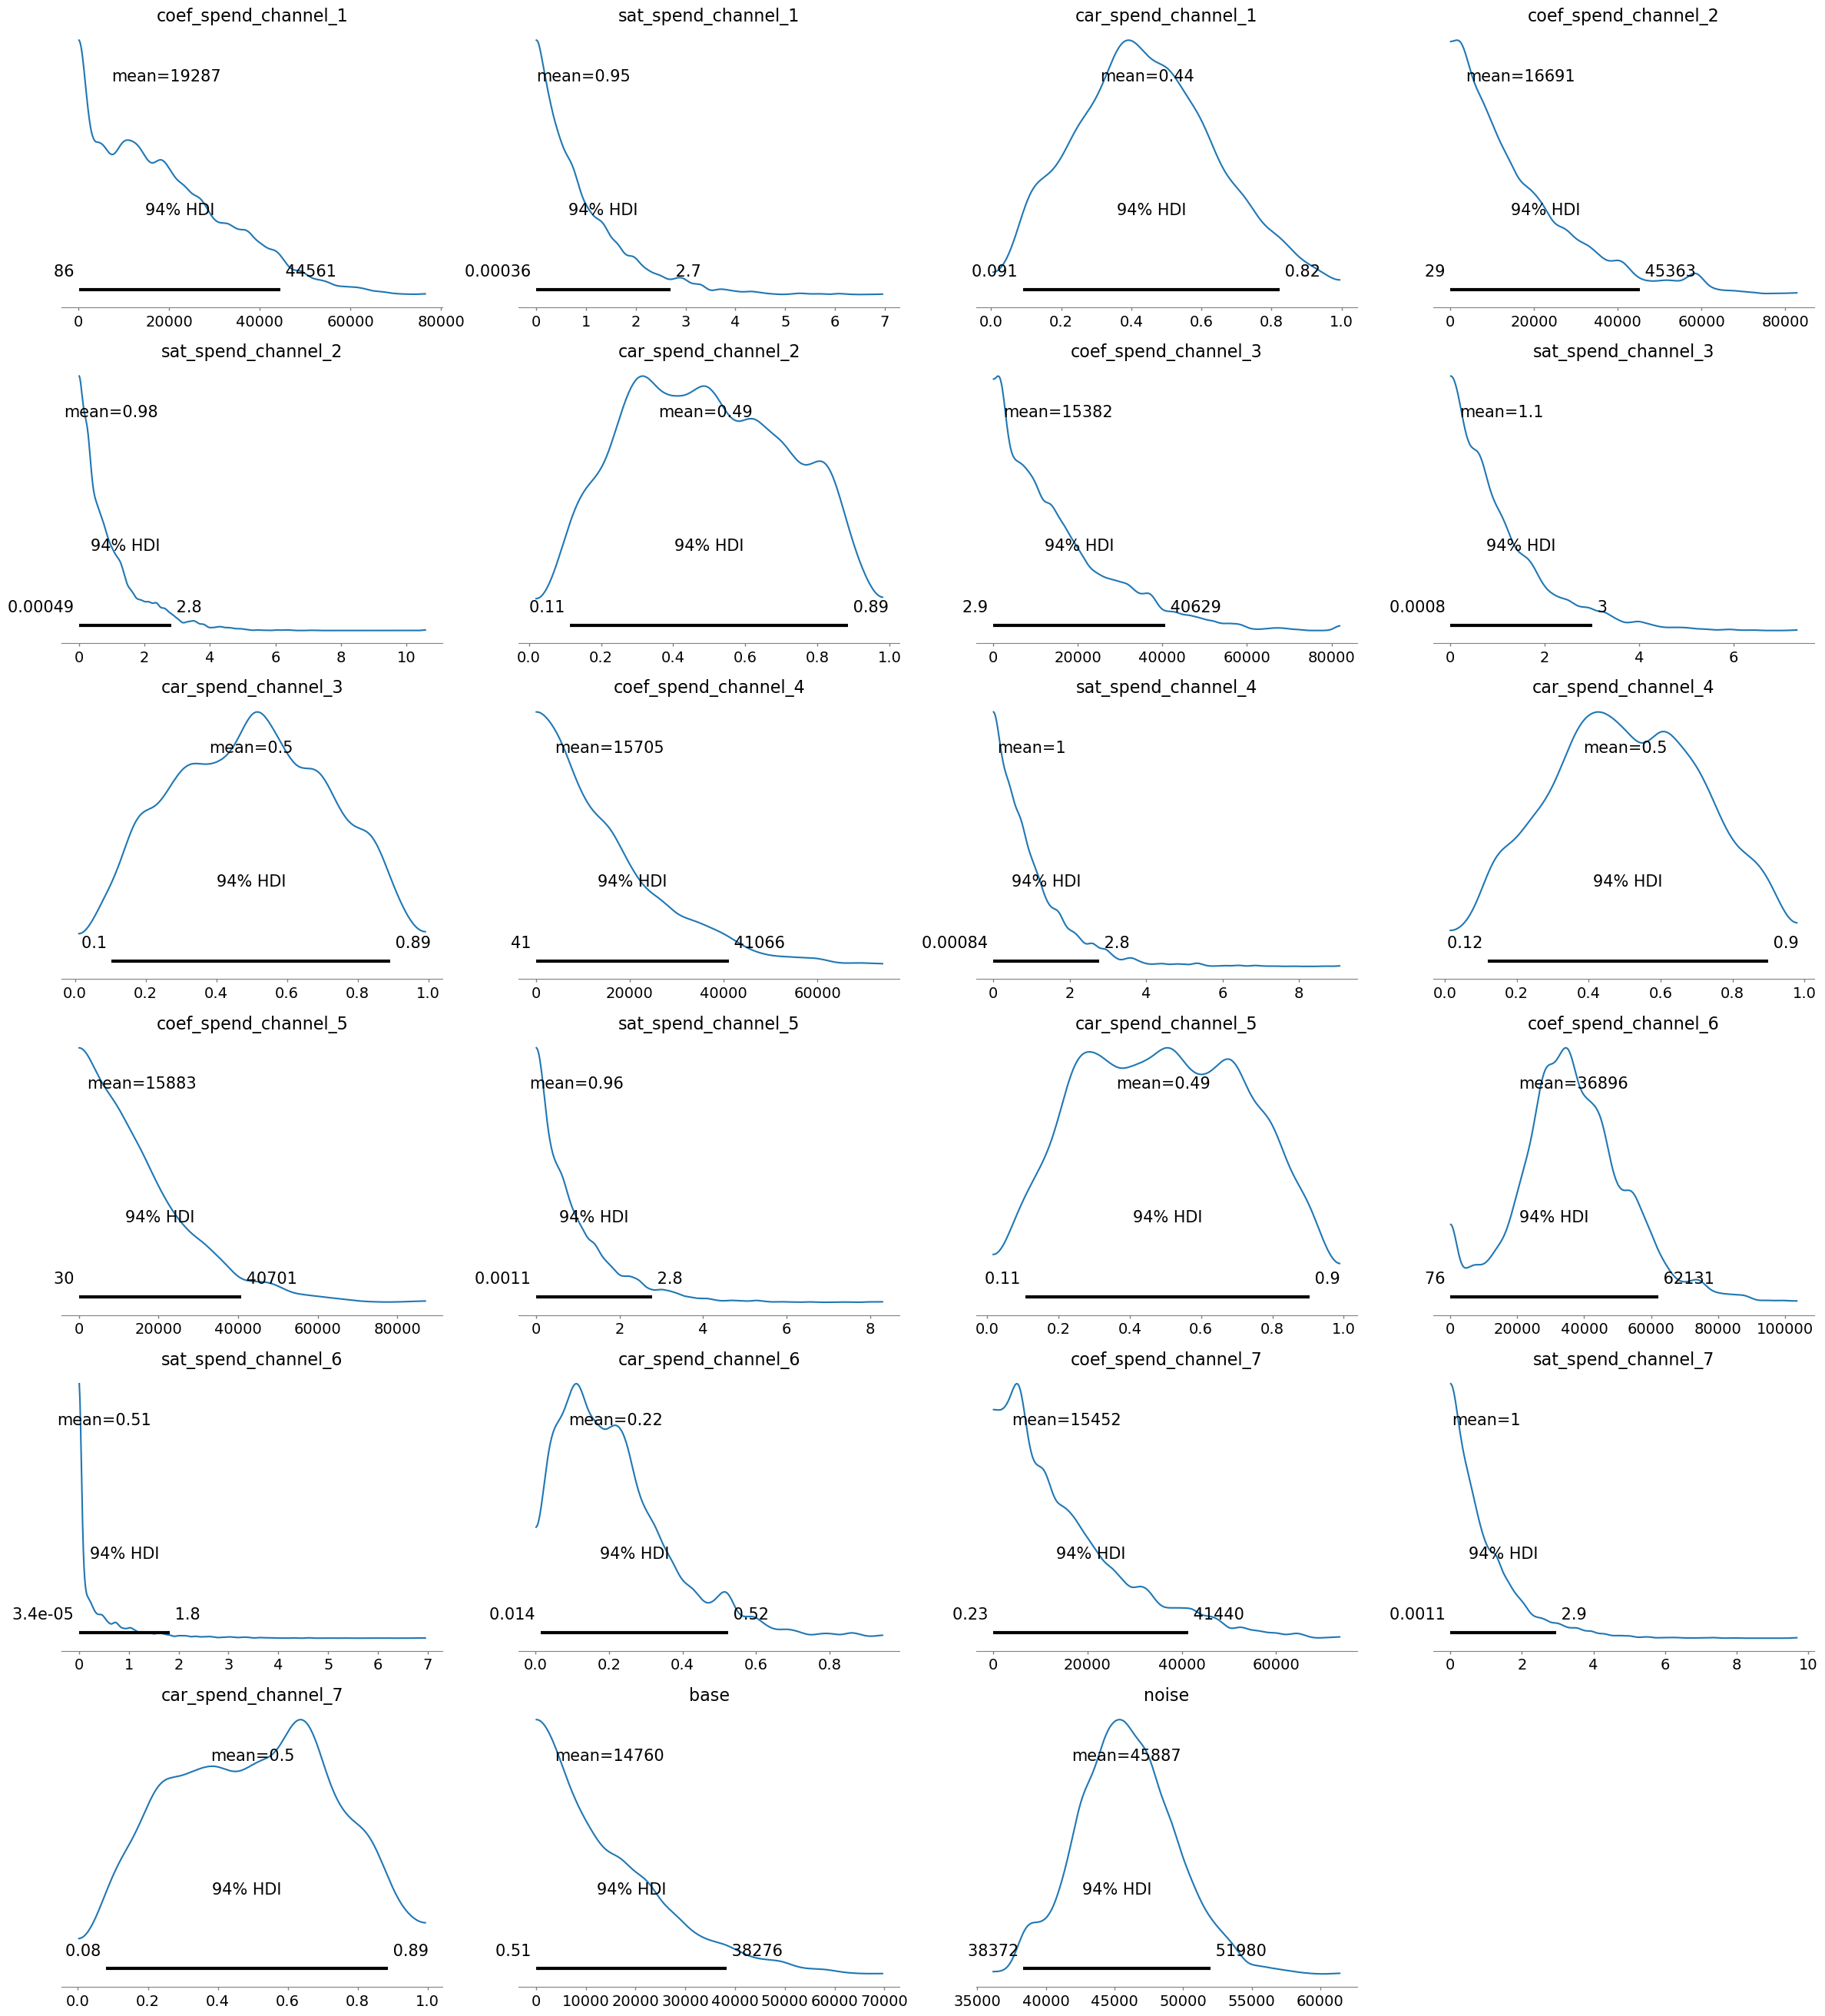

In [7]:
import arviz as az

az.plot_posterior(
    trace,
    var_names=['~contribution'],
    filter_vars='like'
)

<Axes: xlabel='coef_spend_channel_1', ylabel='sat_spend_channel_1'>

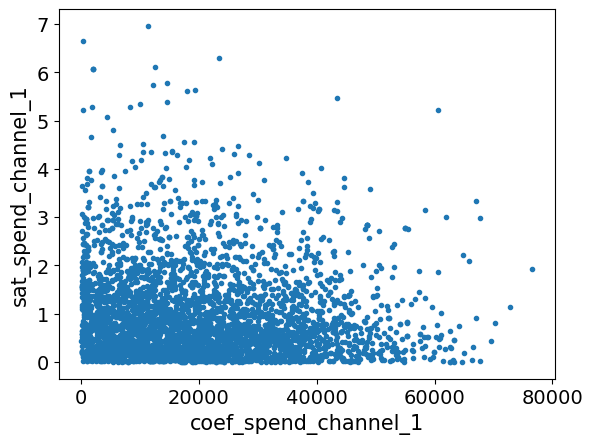

In [11]:
az.plot_pair(
    trace,
    var_names=['coef_spend_channel_1', 'sat_spend_channel_1'],
)

array([[<Axes: >, None],
       [<Axes: xlabel='car_spend_channel_3', ylabel='sat_spend_channel_4'>,
        <Axes: >]], dtype=object)

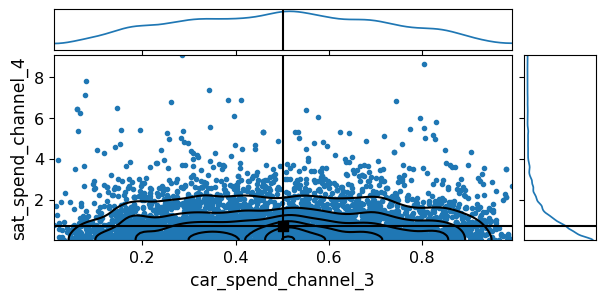

In [17]:
az.plot_pair(
    trace,
    var_names=['car_spend_channel_3', 'sat_spend_channel_4'],
    kind=["scatter", "kde"],
    kde_kwargs={"fill_last": False},
    marginals=True,
    point_estimate="median",
    figsize=(7, 3),
)

NameError: name 'np' is not defined

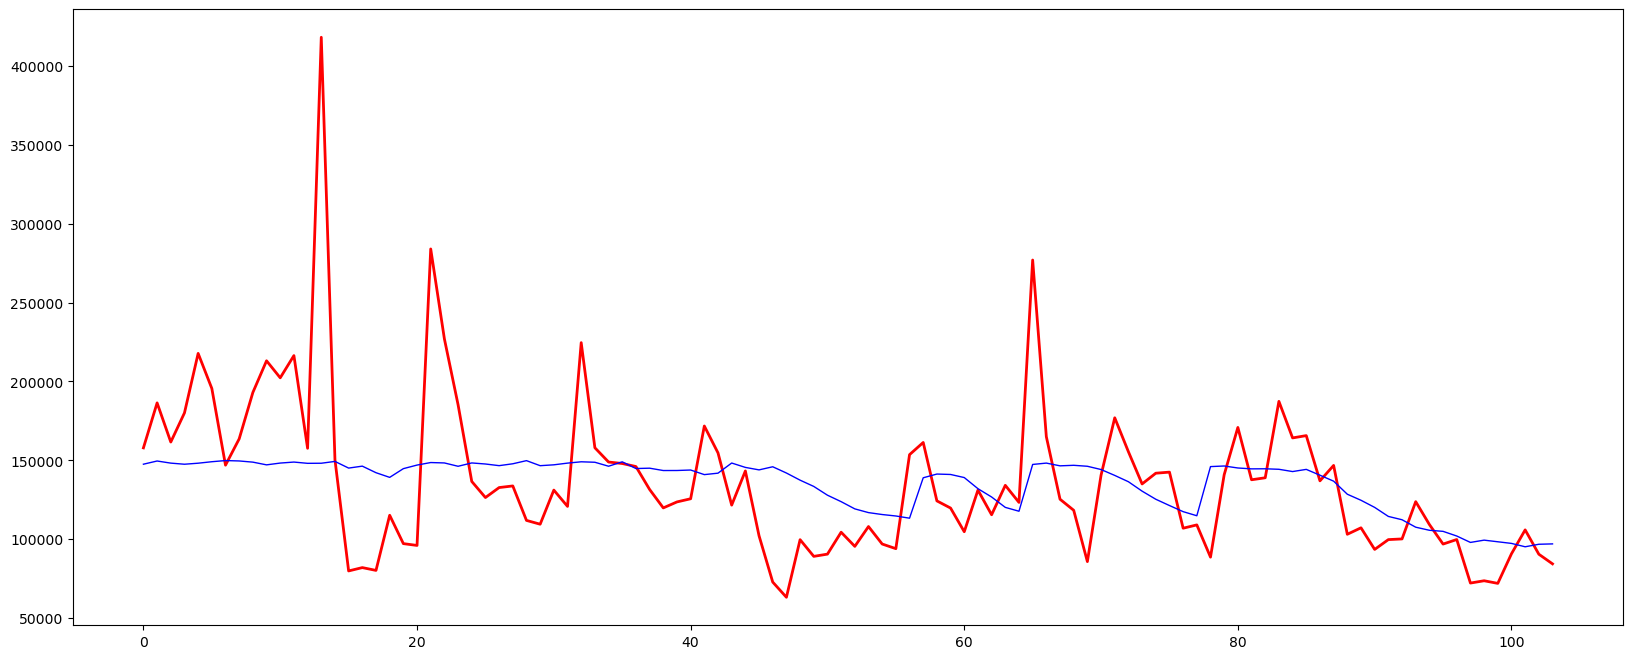

In [18]:
import matplotlib.pyplot as plt

with mmm:
    posterior = pm.sample_posterior_predictive(trace)

means = posterior['revenue'].mean(0)
stds = posterior['revenue'].std(0)


In [34]:
import matplotlib.pyplot as plt

with mmm:
    posterior = pm.sample_prior_predictive(trace)

means = posterior['revenue'].mean(0)
stds = posterior['revenue'].std(0)

TypeError: 'numpy.str_' object cannot be interpreted as an integer

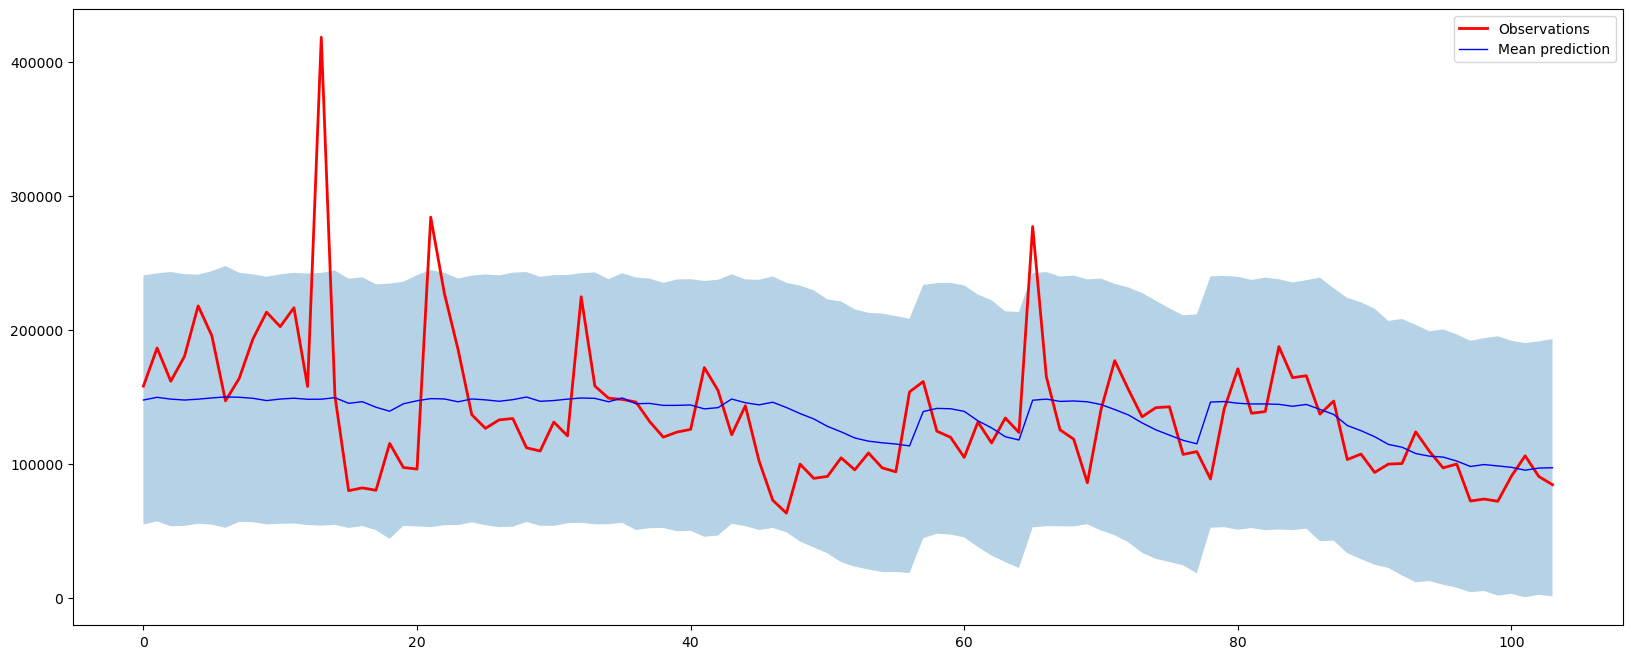

In [19]:
import numpy as np
plt.figure(figsize=(20, 8))
plt.plot(y.values, linewidth=2, c='r', label='Observations')
plt.plot(means, linewidth=1, c='b', label='Mean prediction')
plt.fill_between(np.arange(len(y)), means - 2*stds, means + 2*stds, alpha=0.33)
plt.legend()

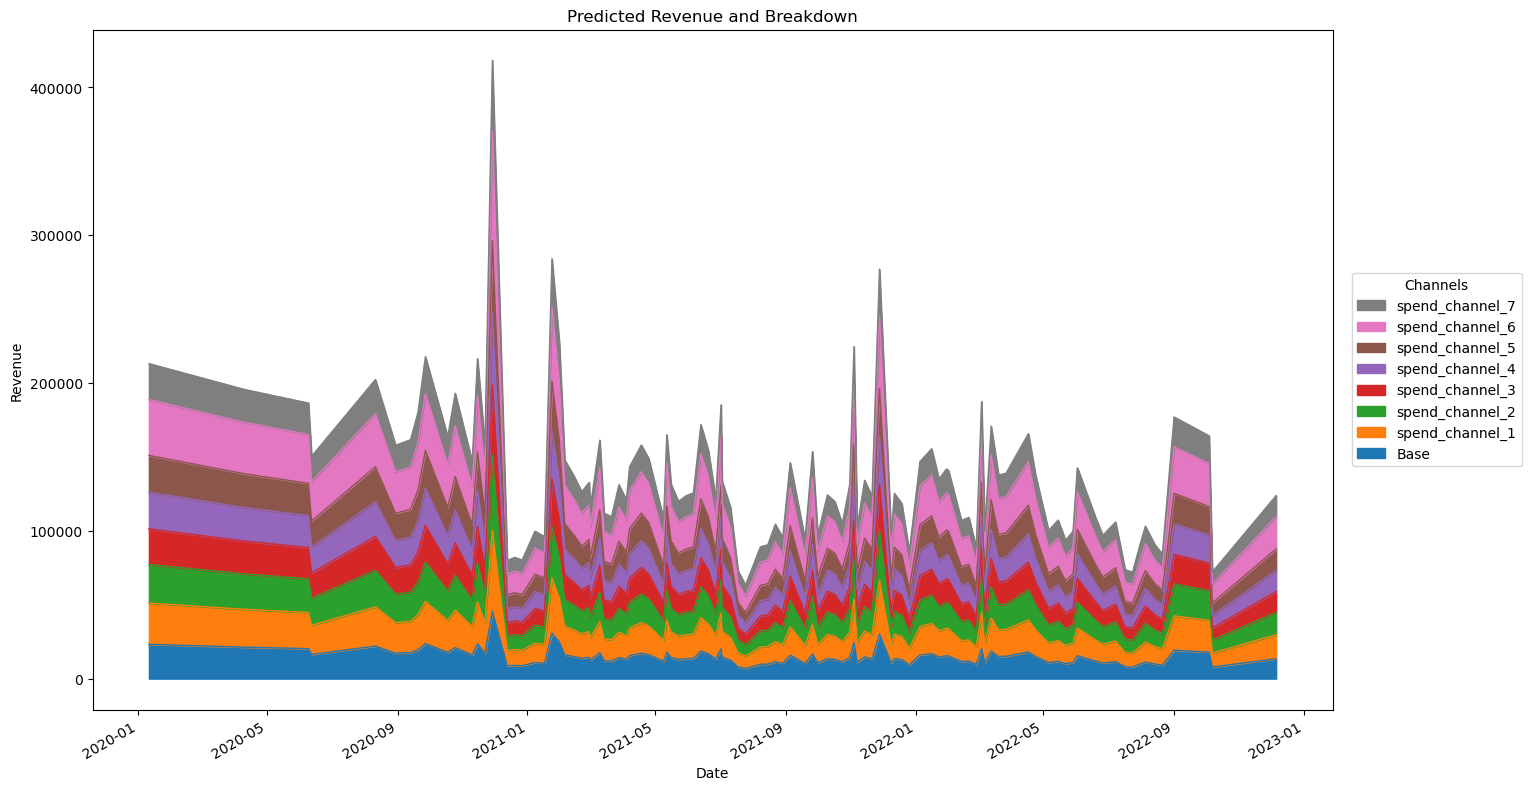

In [33]:
def compute_mean(trace, channel):
    return (trace
            .posterior[f'contribution_{channel}']
            .values
            .reshape(416000, )
            .mean(0)
           )

channels = ['spend_channel_1', 'spend_channel_2', 'spend_channel_3', 'spend_channel_4', 'spend_channel_5', 'spend_channel_6',
           'spend_channel_7']
unadj_contributions = pd.DataFrame(
    {'Base': trace.posterior['base'].values.mean()},
    index=X.index
)

for channel in channels:
    unadj_contributions[channel] = compute_mean(trace, channel)

adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y, axis=0)
                    )

ax = (adj_contributions
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Revenue and Breakdown',
          ylabel='Revenue',
          xlabel='Date'
      )
     )
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)

In [23]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [27]:
posterior

{'revenue': array([[160467.92728313,  94421.61953317,  89188.87511716, ...,
          91991.3485875 ,  50891.38138034, 153978.57784182],
        [108452.15309644, 167801.20666922, 156692.29160892, ...,
          -4138.78063061,  85634.57746218,  95521.45705285],
        [186170.62827861, 183007.78388508, 198019.59065465, ...,
         228448.10501941,  97669.95052672,  87343.79405977],
        ...,
        [ 88285.88018233, 164509.11170814,  75031.28891143, ...,
         165312.04826065, 147059.4363625 , 110946.82519649],
        [219258.76277633,  85768.20545375, 172244.53949674, ...,
         123990.91045848, 142008.75311682,  63047.55182186],
        [ 56344.65652279, 147208.70846135,  18223.24026656, ...,
          96123.97457212, 105700.38297347, 108672.73656417]])}